In [1]:
import pandas as pd
import pickle
from urllib.request import urlopen
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.distributions as dist
import biogeme.results as res
import biogeme.version as ver
from biogeme import models
from biogeme.expressions import (
    Beta,
    DefineVariable,
    log,
    exp,
    Elem,
    bioNormalCdf,
    Variable,
    RandomVariable,
    bioMultSum,
    Integrate
)

Version of Biogeme

In [2]:
print(ver.getText())

biogeme 3.2.8 [2021-09-02]
Version entirely written in Python
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



The estimation of these models may take a while. It you want to run the notebook using pre-estimated results saved on file, set the following variable to `True`

In [3]:
read_results_from_file = True

In [4]:
def get_results_from_url(file):
    pickle_file = f'{url_root}{file}'

    with urlopen(pickle_file) as p:
        data = pickle.load(p)
    return res.bioResults(data)

In [5]:
url_root = (
    'https://courses.edx.org/'
    'asset-v1:EPFLx+ChoiceModels2x+3T2021+type@asset+block@'
)

# Read the data

In [6]:
df = pd.read_table(f'{url_root}optima.dat')
database = db.Database('optima', df)

Extract the variables from the data file

Exclude observations such that the chosen alternative is -1

In [7]:
Choice = Variable('Choice')
database.remove(Choice == -1.0)

# Structural equation for the latent variable

## Variables

Variables directly available in the data file

In [8]:
Gender = Variable('Gender')
FamilSitu = Variable('FamilSitu')
Education = Variable('Education')
ResidChild = Variable('ResidChild')
SocioProfCat = Variable('SocioProfCat')
age = Variable('age')

Creation of new variables, inserted into the database

In [9]:
male = DefineVariable('male', Gender == 1, database)

haveChildren = DefineVariable(
    'haveChildren',
    ((FamilSitu == 3) + (FamilSitu == 4)) > 0,
    database
)

highEducation = DefineVariable('highEducation',
                               Education >= 6,
                               database)

childCenter = DefineVariable(
    'childCenter',
    ((ResidChild == 1) + (ResidChild == 2)) > 0,
    database
)

childSuburb = DefineVariable(
    'childSuburb',
    ((ResidChild == 3) + (ResidChild == 4)) > 0,
    database
)


## Coefficients

In [10]:
coef_intercept = Beta(
    'coef_intercept', 0.0, None, None, 0
)
coef_age_30_less = Beta(
    'coef_age_30_less', 0.0, None, None, 0
)
coef_male = Beta(
    'coef_male', 0.0, None, None, 0
)
coef_haveChildren = Beta(
    'coef_haveChildren', 0.0, None, None, 0
)
coef_highEducation = Beta(
    'coef_highEducation', 0.0, None, None, 0
)
coef_artisans = Beta(
    'coef_artisans', 0.0, None, None, 0
)
coef_employees = Beta(
    'coef_employees', 0.0, None, None, 0
)
coef_child_center = Beta(
    'coef_child_center', 0.0, None, None, 0
)
coef_child_suburb = Beta(
    'coef_child_suburb', 0.0, None, None, 0
)


## Structural equation

If we denote $X_n^*$ the latent variable, the structural equation is
$$ X_n^* = \sum_m \lambda_k x_{nk} + \sigma_\omega \omega_n,$$ where $\omega_n\sim N(0, 1)$.

In [11]:
ACTIVELIFE = (
    coef_intercept
    + coef_child_center * childCenter
    + coef_child_suburb * childSuburb
    + coef_highEducation * highEducation
    + coef_artisans * (SocioProfCat == 5)
    + coef_employees * (SocioProfCat == 6)
    + coef_age_30_less * (age <= 30)
    + coef_male * male
    + coef_haveChildren * haveChildren
)

# Measurement equations

If we denote $X^*$ the latent variable, the measurement equations for one indicator $i$ are:
$$I^*_i = \alpha_i + \beta_i X_n^* + \sigma_i \xi_{in},$$ where $\xi_{in}\sim N(0,1)$, if we assume that the error terms are independent across $i$. Then, this continuous latent indicator is associated with the discrete response as follows: 
$$ I_i = \left\{ \begin{array}{ll} 
   1 & \mbox{if } -\infty < I^*_i \leq \tau_1, \\
   2 & \mbox{if } \tau_1 < I^*_i \leq \tau_2, \\
   3 & \mbox{if } \tau_2 < I^*_i \leq \tau_3, \\
   4 & \mbox{if } \tau_3 < I^*_i \leq \tau_4, \\
   5 & \mbox{if } \tau_4 < I^*_i < +\infty. \\
\end{array} \right. $$
In order to simplify the specification, we assume a symmetrical organization of the thresholds $\tau$ as follows:
$$
\begin{align}
\tau_1 &= -\delta_1 - \delta_2, \\
\tau_2 &= -\delta_1, \\
\tau_3 &= \delta_1, \\
\tau_4 &= \delta_1 + \delta_2.
\end{align}
$$

Note that, if we combine the structural equation and the measurement equations, without a choice model, the error terms are confounded: 
$$
\begin{align}
I^*_i &= \alpha_i + \beta_i X_n^* + \sigma_i \xi_{in},\\
  &= \alpha_i + \beta_i (\sum_m \lambda_k x_{nk} + \sigma_\omega \omega_n) + \sigma_i \xi_{in}, \\
    &= \alpha_i + \beta_i \sum_m \lambda_k x_{nk} + \beta_i \sigma_\omega \omega_n + \sigma_i \xi_{in}, \\
        &= \alpha_i + \beta_i \sum_m \lambda_k x_{nk}  + \sigma'_i \xi'_{in}. \\
\end{align}
$$
Therefore, in the following, we drop the error term of the structural equation. It will be reincluded when the model is combined with the choice model.

For instance, the probability that indicator $i$ takes the value 1, say, is 
$$
\begin{align}
Pr(I_i^* \leq \tau_1) &= Pr(\alpha_i + \beta_i \sum_m \lambda_k x_{nk}  + \sigma'_i \xi'_{in} \leq \tau_1) \\
 &= Pr(\xi'_{in} \leq (\tau_1-\alpha_i-\beta_i \sum_m \lambda_k x_{nk}) / \sigma'_i) \\
 &= \Phi\left(\frac{\tau_1-\alpha_i-\beta_i \sum_m \lambda_k x_{nk}}{ \sigma'_i}\right),
\end{align}
$$
where $\Phi(\cdot)$ is the CDF of the standard normal distribution. 
Similarly, the probability for the value 2 is
$$
Pr(\tau_1 < I^*_i \leq \tau_2) =  \Phi\left(\frac{\tau_2-\alpha_i-\beta_i \sum_m \lambda_k x_{nk}}{ \sigma'_i}\right) -  \Phi\left(\frac{\tau_1-\alpha_i-\beta_i \sum_m \lambda_k x_{nk}}{ \sigma'_i}\right).
$$

In [12]:
indicators = [
    'ResidCh01',
    'ResidCh04',
    'ResidCh05',
    'ResidCh06',
    'LifSty07',
    'LifSty10',
]


We define first the intercept parameters $\alpha_i$ and store them in a dictionary. Note that the first one is normalized to 0.

In [13]:
INTER = {
    k: Beta(f'INTER_{k}', 0, None, None, 0) 
    for k in indicators[1:]
}
INTER[indicators[0]] = Beta(
    f'INTER_{indicators[0]}', 0, None, None, 1
)

We then define the coefficient $\beta_i$, and store them as well in a dictionary.The first one is normalized to one.

In [14]:
B = {
    k: Beta(f'B_{k}', 0, None, None, 0) 
    for k in indicators[1:]
}
B[indicators[0]] = Beta(
    f'B_{indicators[0]}', 1, None, None, 1
)

We then create a dictionary with the measurement equations for $I^*_i$.

In [15]:
MODEL = {
    k: INTER[k] + B[k] * ACTIVELIFE for k in indicators
}

We define the scale parameters $\sigma'_i$ of the error terms, again stored in a dictionary.

In [16]:
SIGMA_STAR = {
    k: Beta(
        f'SIGMA_STAR_{k}', 1, 1.0e-5, None, 0
    ) 
    for k in indicators[1:]
}
SIGMA_STAR[indicators[0]] = Beta(
    f'SIGMA_STAR_{indicators[0]}', 1, None, None, 1
)

We define the thresholds.

In [17]:
delta_1 = Beta('delta_1', 0.1, 1.0e-5, None, 0)
delta_2 = Beta('delta_2', 0.2, 1.0e-5, None, 0)
tau_1 = -delta_1 - delta_2
tau_2 = -delta_1
tau_3 = delta_1
tau_4 = delta_1 + delta_2

We calculate the residuals with respect with each threshold, that are the arguments for the $\Phi(\cdot)$ function above.

In [18]:
tau_1_residual = {
    k: (tau_1 - MODEL[k]) / SIGMA_STAR[k] 
    for k in indicators
}
tau_2_residual = {
    k: (tau_2 - MODEL[k]) / SIGMA_STAR[k] 
    for k in indicators
}
tau_3_residual = {
    k: (tau_3 - MODEL[k]) / SIGMA_STAR[k] 
    for k in indicators
}
tau_4_residual = {
    k: (tau_4 - MODEL[k]) / SIGMA_STAR[k] 
    for k in indicators
}

For each indicator, we associate a dictionary that associates each value of the indicators with the corresponding probability. We associate erroneous values (6, -1, -2) with probability 1 so that they do not contribute to the likelihood function.

In [19]:
Ind = {
    k: {
        1: bioNormalCdf(tau_1_residual[k]),
        2: bioNormalCdf(tau_2_residual[k]) 
            - bioNormalCdf(tau_1_residual[k]),
        3: bioNormalCdf(tau_3_residual[k]) 
            - bioNormalCdf(tau_2_residual[k]),
        4: bioNormalCdf(tau_4_residual[k]) 
            - bioNormalCdf(tau_3_residual[k]),
        5: 1 - bioNormalCdf(tau_4_residual[k]),
        6: 1.0,
        -1: 1.0,
        -2: 1.0,
    }
    for k in indicators
}

# Latent variable model, without the choice model 

We define the log likelihood function

In [20]:
logP = {
    k: log(Elem(Ind[k], Variable(k))) 
    for k in indicators
}
loglike = bioMultSum(logP)

And we estimate the parameters

In [21]:
biogeme_m01 = bio.BIOGEME(database, loglike)
biogeme_m01.modelName = 'm01_latent_variable'

In [22]:
if read_results_from_file:
    structResults = get_results_from_url(
        'm01_latent_variable.pickle'
    )
else:
    structResults = biogeme_m01.estimate()

In [23]:
print(structResults.printGeneralStatistics())

Number of estimated parameters:	26
Sample size:	1906
Excluded observations:	359
Init log likelihood:	-22053.9
Final log likelihood:	-14126.6
Likelihood ratio test for the init. model:	15854.59
Rho-square for the init. model:	0.359
Rho-square-bar for the init. model:	0.358
Akaike Information Criterion:	28305.2
Bayesian Information Criterion:	28449.57
Final gradient norm:	2.0607E-03
Nbr of threads:	16



In [24]:
structResults.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
B_LifSty07,1.101205,0.258570,4.258825,2.055043e-05,0.329748,3.339531,0.000839
B_LifSty10,0.668749,0.191114,3.499210,4.666388e-04,0.223517,2.991945,0.002772
B_ResidCh04,0.240098,0.155763,1.541433,1.232114e-01,0.202259,1.187085,0.235194
B_ResidCh05,2.205324,0.440121,5.010720,5.422678e-07,0.545249,4.044620,0.000052
B_ResidCh06,1.623046,0.406338,3.994326,6.487856e-05,0.671135,2.418361,0.015591
INTER_LifSty07,-0.435314,0.124234,-3.503991,4.583401e-04,0.156394,-2.783456,0.005378
INTER_LifSty10,0.009087,0.091734,0.099059,9.210916e-01,0.104783,0.086722,0.930892
INTER_ResidCh04,0.183328,0.074748,2.452620,1.418200e-02,0.095006,1.929648,0.053650
INTER_ResidCh05,-0.842968,0.210573,-4.003212,6.248821e-05,0.256127,-3.291214,0.000998
INTER_ResidCh06,0.143380,0.191671,0.748054,4.544275e-01,0.310273,0.462108,0.644004


Extract the values of the estimation for the next models.

In [25]:
structBetas = structResults.getBetaValues()
structBetas

{'B_LifSty07': 1.1012049480189057,
 'B_LifSty10': 0.6687491776991253,
 'B_ResidCh04': 0.2400979719518658,
 'B_ResidCh05': 2.2053239945074856,
 'B_ResidCh06': 1.623046032373433,
 'INTER_LifSty07': -0.4353144982916982,
 'INTER_LifSty10': 0.009087023834455657,
 'INTER_ResidCh04': 0.18332813671127693,
 'INTER_ResidCh05': -0.8429682675575829,
 'INTER_ResidCh06': 0.14337994776439433,
 'SIGMA_STAR_LifSty07': 1.1203484524587883,
 'SIGMA_STAR_LifSty10': 0.9749154193748854,
 'SIGMA_STAR_ResidCh04': 0.9387931927478614,
 'SIGMA_STAR_ResidCh05': 1.3684797690972972,
 'SIGMA_STAR_ResidCh06': 1.3612447994986747,
 'coef_age_30_less': 0.4239948873692861,
 'coef_artisans': -0.10507573314740531,
 'coef_child_center': 0.19266861436974295,
 'coef_child_suburb': 0.1163225864087651,
 'coef_employees': -0.0493687361349252,
 'coef_haveChildren': -0.054747696631536315,
 'coef_highEducation': -0.068296711310007,
 'coef_intercept': -0.5527510374784939,
 'coef_male': 0.11799867458973735,
 'delta_1': 0.4842856166097

# Choice model, with  the latent variable model: sequential estimation

## Variables

In [26]:
TimePT = Variable('TimePT')
TimeCar = Variable('TimeCar')
MarginalCostPT = Variable('MarginalCostPT')
CostCarCHF = Variable('CostCarCHF')
distance_km = Variable('distance_km')
TripPurpose = Variable('TripPurpose')
WaitingTimePT = Variable('WaitingTimePT')
TimePT_scaled = DefineVariable(
    'TimePT_scaled', 
    TimePT / 200, database
)
TimeCar_scaled = DefineVariable(
    'TimeCar_scaled', 
    TimeCar / 200, 
    database
)
MarginalCostPT_scaled = DefineVariable(
    'MarginalCostPT_scaled', 
    MarginalCostPT / 10, 
    database
)
CostCarCHF_scaled = DefineVariable(
    'CostCarCHF_scaled', 
    CostCarCHF / 10, 
    database
)
distance_km_scaled = DefineVariable(
    'distance_km_scaled', 
    distance_km / 5, 
    database
)
PurpHWH = DefineVariable(
    'PurpHWH', 
    TripPurpose == 1, 
    database
)
PurpOther = DefineVariable(
    'PurpOther', 
    TripPurpose != 1, 
    database
)


## Latent variable

Here, we need to include the error term for the structural equation, and estimate its scale.

In [27]:
omega = RandomVariable('omega')
density = dist.normalpdf(omega)
sigma_s = Beta('sigma_s', 1, None, None, 0)

For the coefficients, we use the values estimated previously.

In [28]:
est_coef_intercept = structBetas['coef_intercept']
est_coef_age_30_less = structBetas['coef_age_30_less']
est_coef_male = structBetas['coef_male']
est_coef_haveChildren = structBetas['coef_haveChildren']
est_coef_highEducation = structBetas['coef_highEducation']
est_coef_artisans = structBetas['coef_artisans']
est_coef_employees = structBetas['coef_employees']
est_coef_child_center = structBetas['coef_child_center']
est_coef_child_suburb = structBetas['coef_child_suburb']


In [29]:
est_ACTIVELIFE = (
    est_coef_intercept
    + est_coef_child_center * childCenter
    + est_coef_child_suburb * childSuburb
    + est_coef_highEducation * highEducation
    + est_coef_artisans * (SocioProfCat == 5)
    + est_coef_employees * (SocioProfCat == 6)
    + est_coef_age_30_less * (age <= 30)
    + est_coef_male * male
    + est_coef_haveChildren * haveChildren
    + sigma_s * omega
)


## Coefficients

In [30]:
ASC_CAR = Beta(
    'ASC_CAR', 0, None, None, 0
)
ASC_SM = Beta(
    'ASC_SM', 0, None, None, 0
)
BETA_COST_HWH = Beta(
    'BETA_COST_HWH', 0, None, None, 0
)
BETA_COST_OTHER = Beta(
    'BETA_COST_OTHER', 0, None, None, 0
)
BETA_DIST = Beta(
    'BETA_DIST', 0, None, None, 0
)
BETA_TIME_CAR_REF = Beta(
    'BETA_TIME_CAR_REF', -0.1, None, 0, 0
)
BETA_TIME_PT_REF = Beta(
    'BETA_TIME_PT_REF', -0.1, None, 0, 0
)
BETA_WAITING_TIME = Beta(
    'BETA_WAITING_TIME', 0, None, None, 0
)

The coefficients for travel time depend on the latent variable.

In [31]:
BETA_TIME_PT_AL = Beta(
    'BETA_TIME_PT_AL', 1, None, None, 0
)
BETA_TIME_CAR_AL = Beta(
    'BETA_TIME_CAR_AL', 1, None, None, 0
)
BETA_TIME_PT = (
    BETA_TIME_PT_REF * 
    exp(BETA_TIME_PT_AL * est_ACTIVELIFE)
)
BETA_TIME_CAR = (
    BETA_TIME_CAR_REF * 
    exp(BETA_TIME_CAR_AL * est_ACTIVELIFE)
)

## Utility functions

In [32]:
V0 = (
    BETA_TIME_PT * TimePT_scaled
    + BETA_WAITING_TIME * WaitingTimePT
    + BETA_COST_HWH * MarginalCostPT_scaled * PurpHWH
    + BETA_COST_OTHER * MarginalCostPT_scaled * PurpOther
)


In [33]:
V1 = (
    ASC_CAR
    + BETA_TIME_CAR * TimeCar_scaled
    + BETA_COST_HWH * CostCarCHF_scaled * PurpHWH
    + BETA_COST_OTHER * CostCarCHF_scaled * PurpOther
)


In [34]:
V2 = ASC_SM + BETA_DIST * distance_km_scaled


In [35]:
V = {0: V0, 1: V1, 2: V2}

## Log likelihood function

Conditional to omega, we have a logit model (called the kernel)

In [36]:
condprob = models.logit(V, None, Choice)

We integrate over omega using numerical integration

In [37]:
loglike = log(Integrate(condprob * density, 'omega'))

And we estimate the parameters.

In [38]:
biogeme_m02 = bio.BIOGEME(database, loglike)
biogeme_m02.modelName = 'm02_sequential_estimation'

In [39]:
if read_results_from_file:
    seqResults = get_results_from_url(
        'm02_sequential_estimation.pickle'
    )
else:
    seqResults = biogeme_m02.estimate()

In [40]:
print(seqResults.printGeneralStatistics())

Number of estimated parameters:	11
Sample size:	1906
Excluded observations:	359
Init log likelihood:	-2101.799
Final log likelihood:	-1119.839
Likelihood ratio test for the init. model:	1963.92
Rho-square for the init. model:	0.467
Rho-square-bar for the init. model:	0.462
Akaike Information Criterion:	2261.678
Bayesian Information Criterion:	2322.758
Final gradient norm:	9.0656E-03
Nbr of threads:	16



In [41]:
seqResults.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,0.691748,0.121114,5.711560,1.119451e-08,0.125240,5.523369,3.325606e-08
ASC_SM,1.755680,0.238022,7.376113,1.629807e-13,0.234413,7.489682,6.905587e-14
BETA_COST_HWH,-1.860270,0.266549,-6.979094,2.970957e-12,0.397933,-4.674830,2.941974e-06
BETA_COST_OTHER,-0.989018,0.157917,-6.262891,3.779042e-10,0.248458,-3.980619,6.873615e-05
BETA_DIST,-5.074333,0.597694,-8.489850,0.000000e+00,0.577042,-8.793699,0.000000e+00
BETA_TIME_CAR_AL,0.667730,0.315177,2.118587,3.412541e-02,0.271731,2.457324,1.399763e-02
BETA_TIME_CAR_REF,-11.584386,1.997772,-5.798653,6.684957e-09,1.896292,-6.108967,1.002778e-09
BETA_TIME_PT_AL,0.648111,0.305920,2.118565,3.412724e-02,0.264178,2.453307,1.415497e-02
BETA_TIME_PT_REF,-3.589068,0.678779,-5.287536,1.239753e-07,0.567153,-6.328224,2.479987e-10
BETA_WAITING_TIME,-0.030944,0.008573,-3.609644,3.066175e-04,0.011939,-2.591918,9.544244e-03


In [42]:
seqBetas = seqResults.getBetaValues()
seqBetas

{'ASC_CAR': 0.6917475398851577,
 'ASC_SM': 1.7556798407020104,
 'BETA_COST_HWH': -1.860270305188812,
 'BETA_COST_OTHER': -0.9890184285333976,
 'BETA_DIST': -5.074333035856518,
 'BETA_TIME_CAR_AL': 0.6677302325521346,
 'BETA_TIME_CAR_REF': -11.584385587754586,
 'BETA_TIME_PT_AL': 0.6481106468376574,
 'BETA_TIME_PT_REF': -3.5890682268388465,
 'BETA_WAITING_TIME': -0.03094425377509753,
 'sigma_s': 2.0595400068101823}

# Choice model, with  the latent variable model: simultaneous estimation

## Latent variable

In [43]:
ACTIVELIFE = (
    coef_intercept
    + coef_child_center * childCenter
    + coef_child_suburb * childSuburb
    + coef_highEducation * highEducation
    + coef_artisans * (SocioProfCat == 5)
    + coef_employees * (SocioProfCat == 6)
    + coef_age_30_less * (age <= 30)
    + coef_male * male
    + coef_haveChildren * haveChildren
    + sigma_s * omega
)



# Utility functions

Travel time coefficients

In [44]:
BETA_TIME_PT_AL = Beta(
    'BETA_TIME_PT_AL', 1, None, None, 0
)
BETA_TIME_CAR_AL = Beta(
    'BETA_TIME_CAR_AL', 1, None, None, 0
)
BETA_TIME_PT = (
    BETA_TIME_PT_REF * 
    exp(BETA_TIME_PT_AL * ACTIVELIFE)
)
BETA_TIME_CAR = (
    BETA_TIME_CAR_REF * 
    exp(BETA_TIME_CAR_AL * ACTIVELIFE)
)

In [45]:
V0 = (
    BETA_TIME_PT * TimePT_scaled
    + BETA_WAITING_TIME * WaitingTimePT
    + BETA_COST_HWH * MarginalCostPT_scaled * PurpHWH
    + BETA_COST_OTHER * MarginalCostPT_scaled * PurpOther
)

In [46]:
V1 = (
    ASC_CAR
    + BETA_TIME_CAR * TimeCar_scaled
    + BETA_COST_HWH * CostCarCHF_scaled * PurpHWH
    + BETA_COST_OTHER * CostCarCHF_scaled * PurpOther
)

In [47]:
V = {0: V0, 1: V1, 2: V2}

## Log likelihood function

Conditional to omega, we have a logit model (called the kernel) for the choice

In [48]:
condprob = models.logit(V, None, Choice)

Conditional to omega, we have the product of the ordered probit probability for each indicator.

In [49]:
prob_indicators = Elem(
    Ind[indicators[0]], 
    Variable(indicators[0])
)
for k in indicators[1:]:
    prob_indicators *= Elem(Ind[k], Variable(k))


The likelihood, conditional on omega, is the product of the two.

In [50]:
condlike = prob_indicators * condprob

We integrate over omega using numerical integration

In [51]:
loglike = log(Integrate(condlike * density, 'omega'))

Create the Biogeme object

In [52]:
biogeme_m03 = bio.BIOGEME(database, loglike)
biogeme_m03.modelName = 'm03_simultaneous_estimation'

Use the estimated values as starting values. 

In [53]:
biogeme_m03.changeInitValues(structBetas | seqBetas)

In [54]:
if read_results_from_file:
    results = get_results_from_url(
        'm03_simultaneous_estimation.pickle'
    )
else:
    results = biogeme_m03.estimate()

In [55]:
print(results.printGeneralStatistics())

Number of estimated parameters:	37
Sample size:	1906
Excluded observations:	359
Init log likelihood:	-15246.44
Final log likelihood:	-15246.39
Likelihood ratio test for the init. model:	0.09686514
Rho-square for the init. model:	3.18e-06
Rho-square-bar for the init. model:	-0.00242
Akaike Information Criterion:	30566.78
Bayesian Information Criterion:	30772.23
Final gradient norm:	2.8090E-02
Nbr of threads:	16



In [56]:
results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,0.694171,0.121948,5.692361,1.252945e-08,0.129368,5.365843,8.057198e-08
ASC_SM,1.759646,0.239427,7.349396,1.991740e-13,0.238797,7.368811,1.720846e-13
BETA_COST_HWH,-1.861603,0.267024,-6.971661,3.132161e-12,0.399575,-4.658959,3.178120e-06
BETA_COST_OTHER,-0.990762,0.158746,-6.241160,4.343368e-10,0.250101,-3.961452,7.449527e-05
BETA_DIST,-5.078340,0.600055,-8.463119,0.000000e+00,0.582168,-8.723158,0.000000e+00
BETA_TIME_CAR_AL,0.673587,0.343149,1.962959,4.965098e-02,0.324173,2.077862,3.772211e-02
BETA_TIME_CAR_REF,-11.585466,2.125612,-5.450415,5.025242e-08,2.098832,-5.519959,3.390787e-08
BETA_TIME_PT_AL,0.654151,0.333359,1.962301,4.972749e-02,0.315634,2.072497,3.821915e-02
BETA_TIME_PT_REF,-3.579375,0.710361,-5.038814,4.684256e-07,0.633240,-5.652478,1.581514e-08
BETA_WAITING_TIME,-0.031055,0.008600,-3.611173,3.048156e-04,0.012071,-2.572718,1.009035e-02


# Simulation

In order to illustrate the latent variables, we calculate the average value of the ACTIVELIFE latent variable (that is, without the error term) for each individual in the sample.

In [57]:
ACTIVELIFE = (
    coef_intercept
    + coef_child_center * childCenter
    + coef_child_suburb * childSuburb
    + coef_highEducation * highEducation
    + coef_artisans * (SocioProfCat == 5)
    + coef_employees * (SocioProfCat == 6)
    + coef_age_30_less * (age <= 30)
    + coef_male * male
    + coef_haveChildren * haveChildren
)

In [58]:
simulate = {'ACTIVELIFE': ACTIVELIFE}

In [59]:
biosim = bio.BIOGEME(database, simulate)

In [60]:
simresults = biosim.simulate(
    theBetaValues=results.getBetaValues()
)

In [61]:
simresults.describe()

,ACTIVELIFE
count,1906.000000
mean,-0.444100
std,0.175964
min,-0.722118
25%,-0.553913
50%,-0.489122
75%,-0.376059
max,0.189660


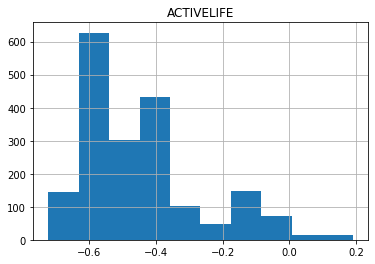

In [62]:
_ = simresults.hist()